# Showcase of custom transformers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# To automatically reload module after src code changes
%load_ext autoreload
%autoreload 1
%aimport src.ImputeByGroup, src.PandasColumnTransformer
from src.ImputeByGroup import ImputeNumericalByGroup, ImputeCategoricalByGroup
from src.PandasColumnTransformer import PandasColumnTransformer

## Load data

In [2]:
raw_train = pd.read_csv("tests/titanic_train.csv")
raw_test = pd.read_csv("tests/titanic_test.csv")
y_train = raw_train.pop("Survived")

In [3]:
raw_train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
raw_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Imputation via groupby, as part of a pipeline

In [5]:
""" 
    Why don't we impute using the dataframe-wide median? Because data contains heterogeneous groups 
    e.g. 1st-class Titanic passengers tended to be older than 3rd-class passengers
"""

print(raw_train.groupby("Pclass")["Age"].median(), "\n")
print(raw_train["Age"].median())

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64 

28.0


In [6]:
# copy == False in 2nd step
# b/c only need to make copy once to protect original data
pl = make_pipeline(
    ImputeNumericalByGroup(target_col="Age", groupby_col=["Pclass", "Embarked"], return_df=True),
    ImputeCategoricalByGroup(target_col="Embarked", groupby_col=["Pclass"], return_df=True, copy=False)
).fit(raw_train)

In [7]:
# No more missing values in Age and Embarked!
print(pl.transform(raw_train).isna().sum(), "\n")

print(pl.transform(raw_test).isna().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## `ColumnTransformer` + `pandas`

Train a logistic regression model, and easily attribute each weight to its column.

In [8]:
""" PandasColumnTransformer works with pipelines! """

column_transformer = PandasColumnTransformer([
    ("numerical", StandardScaler(), ["Age", "Fare"]),
    ("categorical_cardinal", OneHotEncoder(), ["Embarked"])
], remainder="drop")

# Repeating the imputation logic in previous section
pl = make_pipeline(
    ImputeNumericalByGroup(target_col="Age", groupby_col=["Pclass", "Embarked"], return_df=True),
    ImputeCategoricalByGroup(target_col="Embarked", groupby_col=["Pclass"], return_df=True, copy=False),
    column_transformer
).fit(raw_train)

In [9]:
X_train = pl.transform(raw_train)

Text(0.5, 0, 'Coefficient size')

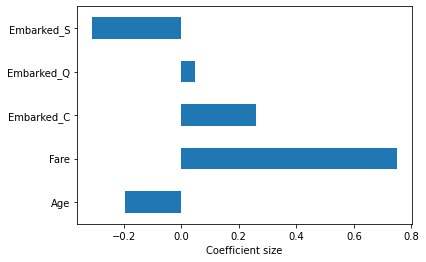

In [10]:
""" Can quickly see that Fare (Embarked_S) has 
the largest positive (negative) impact among features used """

lr = LogisticRegression().fit(X_train, y_train)
pd.Series(lr.coef_[0], name="coef", index=X_train.columns).plot.barh()
plt.xlabel("Coefficient size")